In [5]:
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk  import pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn, stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.sparse import hstack
import pickle
import seaborn as sns

In [6]:
np.random.seed(500)

In [7]:
class TrainMLModels:
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)
    stop_words = set(stopwords.words('english'))


    def __performTextPreprocessing_PUBHEALTH(self, dataframe_series):
        '''
        This function performs text preprocessing on the dataframe series. It do the following tasks:
        1. Tokenize the text
        2. Remove stop words
        3. Lemmatize the text, and returns the dataframe series, containing lemmatized text in form of a space seperated string
        '''
        dataframe_series = dataframe_series.str.lower()
        
        # Word tokenization
        dataframe_series = [word_tokenize(text) for text in dataframe_series]

        # Remove stop words and non-alphanumeric characters (TODO: -- check how much do we need alphanumeric characters)
        stop_words = set(stopwords.words('english'))
        dataframe_series = [[word for word in text if word not in stop_words and word.isalpha()] for text in dataframe_series]

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        for index, text in enumerate(dataframe_series):
            sentence = ""
            for word in text:
                word = lemmatizer.lemmatize(word)
                sentence += word + " "
            sentence = sentence.strip()
            dataframe_series[index] = sentence
        return dataframe_series
    

    def __perform_tfidf_vectorization_PUBHEALTH(self, preprocessed_dataframe_series):
        ''' Performs tfidf vectorization on the preprocessed dataframe series'''
        return self.tfidf_vectorizer.fit_transform(preprocessed_dataframe_series)
    
    def __generate_claim_label_mapping(self, dataframe_series):
        possible_labels = dataframe_series.unique()
        label_dict = {}
        for index, possible_label in enumerate(possible_labels):
            label_dict[possible_label] = index
        return label_dict
    
    def get_train_test_Variables_PUBHEALTH(self):
        '''Preform all data preprocessing tasks and return x_train, y_train, x_test, y_test, y_text_to_integer_mapping'''
        medical_data_train = pd.read_csv(r"./data/PUBHEALTH/medical_data_cleaned_train.tsv", sep='\t')
        medical_data_test = pd.read_csv(r"./data/PUBHEALTH/medical_data_cleaned_test.tsv", sep='\t')
        
        # Merge claim and main_text columns into single one
        medical_data_train['claim'] = medical_data_train['claim'] + '. ' + medical_data_train['main_text']
        medical_data_test['claim'] = medical_data_test['claim'] + '. ' + medical_data_test['main_text']
        medical_data_train.drop(columns=['main_text'], inplace=True)
        medical_data_test.drop(columns=['main_text'], inplace=True)
        
        # Label encode claim label categories
        label_dict = self.__generate_claim_label_mapping(medical_data_train['label'])
        y_train = medical_data_train['label'].replace(label_dict)
        y_test = medical_data_test['label'].replace(label_dict)


        # Perform text preprocessing
        medical_data_train['claim'] = self.__performTextPreprocessing_PUBHEALTH(
            medical_data_train['claim']
        )
        medical_data_test['claim'] = self.__performTextPreprocessing_PUBHEALTH(
            medical_data_test['claim']
        )

        # Perform tfidf vectorization
        x_train = self.__perform_tfidf_vectorization_PUBHEALTH(medical_data_train['claim'])
        x_test = self.__perform_tfidf_vectorization_PUBHEALTH(medical_data_test['claim'])
        return (x_train, y_train, x_test, y_test, label_dict)
    
    def __preprocesFactDescription_NEWS(self, sentence):
        lemma_words = []
        wordnet_lemmatizer = WordNetLemmatizer()
        word_tokens = word_tokenize(sentence) 
        for word in word_tokens: 
            if word not in self.stop_words: 
                new_word = re.sub('[^a-zA-Z]', '',word)
                new_word = new_word.lower()
                new_word = wordnet_lemmatizer.lemmatize(new_word)
                lemma_words.append(new_word)
        return " ".join(lemma_words)

    def get_train_test_Variables_NEWS(self):
        '''Preform all data preprocessing tasks and return x_train, y_train, x_test, y_test on NEWS dataset'''
        df_true = pd.read_csv("./data/NEWS/True.csv")
        df_fake = pd.read_csv("./data/NEWS/Fake.csv")
        df_true["label"] = "1"
        df_fake["label"] = "0"
        df = pd.concat([df_true, df_fake])
        df = df.sample(frac=1).reset_index(drop=True)
        df = df.dropna()
        df.text = df.title + df.text
        df.drop(columns=['title', "subject", "date"], axis=1, inplace=True)
        X = df.text
        Y = df.label
        X = [self.__preprocesFactDescription_NEWS(x) for x in X]
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
        return (X_train, y_train, X_test, y_test)
    
    def predictHelper_NEWS(self, news):
        news = self.__preprocesFactDescription_NEWS(news)
        return news
        






In [8]:
model_trainer = TrainMLModels()
# data = model_trainer.get_train_test_Variables_PUBHEALTH()

In [9]:
# x_train = data[0]
# y_train = data[1]
# x_test = data[2]
# y_test = data[3]
# label_dict = data[4]

In [10]:
news_data = model_trainer.get_train_test_Variables_NEWS()

In [66]:
# Vectorize data

In [12]:
vectorizer= TfidfVectorizer()
x_train_news = vectorizer.fit_transform(news_data[0])
y_train_news = news_data[1]
x_test_news = vectorizer.transform(news_data[2])
y_test_news = news_data[3]

In [11]:
vectorizer_save_file = "./saved_models/vectorizer_SVM_NB.pickle"
# # Save Vectorizer
# with open(vectorizer_save_file, "wb") as file:
#     pickle.dump(vectorizer, file)

# Load saved Vectorizer
with open(vectorizer_save_file, "rb") as file:
    saved_vectorizer = pickle.load(file)


### Gaussian Naive Bayes

In [67]:
bernoulli_nb = naive_bayes.BernoulliNB()
bernoulli_nb.fit(x_train_news, y_train_news)

BernoulliNB()

In [68]:
print("Training set score: ", bernoulli_nb.score(x_train_news, y_train_news))
print("Testing set score: ", bernoulli_nb.score(x_test_news, y_test_news))

Training set score:  0.9781168216493124
Testing set score:  0.9733853006681514


In [79]:
y_test_pred_bernoulli_nb = bernoulli_nb.predict(x_test_news)

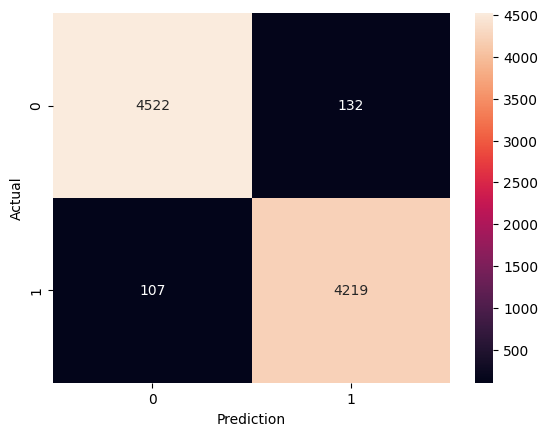

In [80]:
ax = sns.heatmap(confusion_matrix(y_test_news,y_test_pred_bernoulli_nb), annot=True, fmt="d")
ax.set(xlabel='Prediction', ylabel='Actual')
plt.show()

In [69]:
bernoulli_model_save_file = "./saved_models/bernoulli_nb_classifier.pkl"
with open(bernoulli_model_save_file, "wb") as file:
    pickle.dump(bernoulli_nb, file)

In [70]:
# Load the model from the file
with open(bernoulli_model_save_file, "rb") as file:
    saved_bernoulli_nb_model = pickle.load(file)

In [73]:
news = "Russia says closely monitoring signals from Trump's team: RIA"
x_preprocessed = model_trainer.predictHelper_NEWS(news)
df = pd.DataFrame([x_preprocessed])
x = df.iloc[:, 0]
print(x)
x_vectorized = saved_vectorizer.transform(x)
print(saved_bernoulli_nb_model.predict(x_vectorized)=='1')

0    russia say closely monitoring signal trump s t...
Name: 0, dtype: object
[ True]


In [74]:
x_pred = saved_bernoulli_nb_model.predict(x_vectorized)

In [75]:
print(x_pred=='1')

[ True]


### Multinomial Naive Bayes classifier

In [82]:
multinomial_nb = naive_bayes.MultinomialNB()
multinomial_nb.fit(x_train_news,  y_train_news)

MultinomialNB()

In [83]:
print("Training set score: ", multinomial_nb.score(x_train_news, y_train_news))
print("Testing set score: ", multinomial_nb.score(x_test_news, y_test_news))

Training set score:  0.9514449579597973
Testing set score:  0.9443207126948775


In [84]:
y_test_pred_multinomial_nb = multinomial_nb.predict(x_test_news)

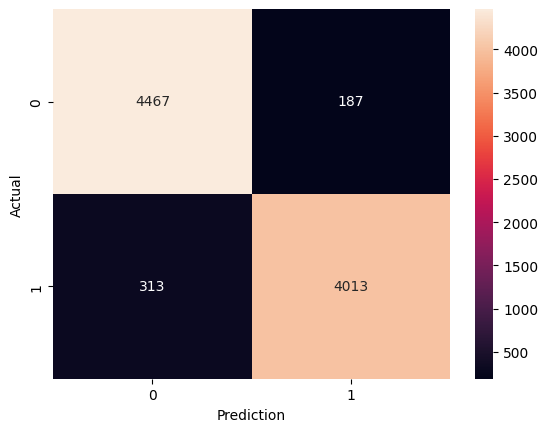

In [85]:
ax = sns.heatmap(confusion_matrix(y_test_news,y_test_pred_multinomial_nb), annot=True, fmt="d")
ax.set(xlabel='Prediction', ylabel='Actual')
plt.show()

In [86]:
# multinomial_model_save_file = "./saved_models/multinomial_nb_classifier.pkl"
# with open(multinomial_model_save_file, "wb") as file:
#     pickle.dump(multinomial_nb, file)

# # Load the model from the file
# with open(multinomial_model_save_file, "rb") as file:
#     saved_multinomial_nb_model = pickle.load(file)

In [87]:
x_pred_multinomial = multinomial_nb.predict(x_vectorized)
print(x_pred_multinomial=='1')

[ True]


### SVM Classifier

In [13]:
svm_classifier = svm.SVC()
svm_classifier.fit(x_train_news, y_train_news)

SVC()

In [15]:
print("Testing set score: ", svm_classifier.score(x_test_news, y_test_news))

Testing set score:  0.9935412026726058


In [16]:
y_test_pred_svm_classifier = svm_classifier.predict(x_test_news)

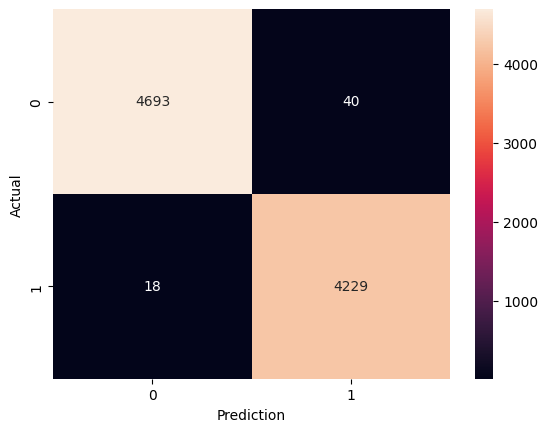

In [17]:
ax = sns.heatmap(confusion_matrix(y_test_news,y_test_pred_svm_classifier), annot=True, fmt="d")
ax.set(xlabel='Prediction', ylabel='Actual')
plt.show()

In [14]:
svm_model_save_file = "./saved_models/svm_classifier.pkl"
with open(svm_model_save_file, "wb") as file:
    pickle.dump(svm_classifier, file)

# # Load the model from the file
# with open(svm_model_save_file, "rb") as file:
#     saved_svm_model = pickle.load(file)